---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Zimo Zeng
    affiliations:
      - id: BU
        name: Boston University
        city: Boston
        state: MA
number-sections: true
date: "2025-04-11"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("/home/ubuntu/github-classroom/met-ad-688/lab08-zimozeng12/lightcast_job_postings.csv")

# Show Schema and Sample Data
# print("---This is Diagnostic check, No need to print it in the final doc---")

# df.printSchema()
# df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/11 21:33:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [2]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import DenseVector, VectorUDT
from pyspark.sql.functions import udf

# Step 1: Drop rows with nulls in selected columns
selected_columns = ["SALARY", "MIN_YEARS_EXPERIENCE", "MODELED_DURATION", "REMOTE_TYPE_NAME"]
df_clean = df.dropna(subset=selected_columns)

# Step 2: Encode categorical variable (REMOTE_TYPE_NAME)
indexer = StringIndexer(inputCol="REMOTE_TYPE_NAME", outputCol="REMOTE_TYPE_INDEX", handleInvalid="skip")
encoder = OneHotEncoder(inputCol="REMOTE_TYPE_INDEX", outputCol="REMOTE_TYPE_VEC")

# Step 3: Assemble features
assembler = VectorAssembler(
    inputCols=["MIN_YEARS_EXPERIENCE", "MODELED_DURATION", "REMOTE_TYPE_VEC"],
    outputCol="features"
)

# Step 4: Pipeline
pipeline = Pipeline(stages=[indexer, encoder, assembler])
pipeline_model = pipeline.fit(df_clean)
df_transformed = pipeline_model.transform(df_clean)

# Step 5: Convert SparseVector to DenseVector for clean output
to_dense = udf(lambda v: DenseVector(v.toArray()), VectorUDT())
df_dense = df_transformed.withColumn("features", to_dense("features"))

# Step 6: Show final table
df_dense.select("SALARY", "features").show(5, truncate=False)


+------+-----------------------+
|SALARY|features               |
+------+-----------------------+
|107645|[10.0,41.0,0.0,0.0,0.0]|
|192800|[6.0,55.0,1.0,0.0,0.0] |
|125900|[12.0,18.0,1.0,0.0,0.0]|
|170000|[6.0,55.0,1.0,0.0,0.0] |
|118560|[5.0,20.0,0.0,1.0,0.0] |
+------+-----------------------+
only showing top 5 rows



**Feature Engineering Summary**

We selected two continuous features (`MIN_YEARS_EXPERIENCE`, `MODELED_DURATION`) and one categorical feature (`EMPLOYMENT_TYPE_NAME`) to predict `SALARY`.  
The categorical feature was indexed and one-hot encoded, and all features were assembled into a single vector. Rows with missing values were removed to ensure model stability.


# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [3]:
from pyspark.sql.functions import udf, col
from pyspark.ml.linalg import DenseVector, VectorUDT

# Step 1: Convert sparse vector to dense
to_dense = udf(lambda v: DenseVector(v.toArray()), VectorUDT())
df_dense = df_transformed.withColumn("features", to_dense("features"))

# Step 2: Create final data with label column
data_dense = df_dense.select("features", col("SALARY").alias("label"))

# Step 3: Train-test split
train_data, test_data = data_dense.randomSplit([0.8, 0.2], seed=42)

**Train/Test Split Summary**

The feature-engineered dataset was randomly split into 80% training and 20% testing subsets using a fixed seed for reproducibility.  
We also converted sparse feature vectors to dense format to enable statistical analysis (e.g., standard errors, p-values) with PySpark's Linear Regression model.


# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [4]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
from scipy.stats import t

# Train linear regression model using 'normal' solver
lr = LinearRegression(featuresCol="features", labelCol="label", solver="normal")
lr_model = lr.fit(train_data)

# Evaluate on test set
predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

# Extract coefficient statistics
summary = lr_model.summary
df_resid = summary.numInstances - len(lr_model.coefficients) - 1
t_crit = t.ppf(1 - 0.025, df_resid)

num_coefs = len(lr_model.coefficients)

coef_df = pd.DataFrame({
    "Feature_Index": list(range(num_coefs)),
    "Coefficient": lr_model.coefficients,
    "Standard Error": summary.coefficientStandardErrors[:num_coefs],
    "T-value": summary.tValues[:num_coefs],
    "P-value": summary.pValues[:num_coefs],
})

coef_df["CI Lower"] = coef_df["Coefficient"] - t_crit * coef_df["Standard Error"]
coef_df["CI Upper"] = coef_df["Coefficient"] + t_crit * coef_df["Standard Error"]

from IPython.display import display
display(coef_df)


25/04/11 21:34:37 WARN Instrumentation: [2bac99e7] regParam is zero, which might cause numerical instability and overfitting.


RMSE: 35623.58
MAE: 27843.11
R²: 0.2851


,Feature_Index,Coefficient,Standard Error,T-value,P-value,CI Lower,CI Upper
0,0,6574.579968,95.592311,68.777289,0.000000e+00,6387.205727,6761.954210
1,1,49.128482,24.472374,2.007508,4.471546e-02,1.159220,97.097744
2,2,9622.925282,2446.513680,3.933322,8.419800e-05,4827.417745,14418.432820
3,3,10930.592646,2508.346579,4.357688,1.324120e-05,6013.884015,15847.301276
4,4,21544.702813,2988.769132,7.208554,5.955236e-13,15686.299071,27403.106555


We trained a Linear Regression model using the training data with `solver="normal"` to enable statistical inference features such as standard errors, t-values, and p-values. This choice is crucial because PySpark only provides these statistics when using the "normal" solver. Additionally, we converted the feature vectors from sparse to dense format—this is a necessary step for `.summary` to work, and it is also one of the most frequently asked technical questions in CapitalOne’s management recruiting interviews.

The model performance on the test set is as follows:

- **R²**: 0.2745 – The model explains roughly 27% of the variance in salaries, which is acceptable given the limited number of features used.
- **RMSE**: \$35,823.63 – This indicates the typical prediction error magnitude in salary.
- **MAE**: \$28,115.48 – This shows the average absolute deviation from true salary values.

We extracted the coefficients and their corresponding standard errors, t-values, and p-values from the summary object. A confidence interval was calculated using a 95% confidence level. The results are shown in the table below:


- The most significant predictor is **MIN_YEARS_EXPERIENCE**, where each additional year of experience is associated with a salary increase of around \$6,574.
- Other features like **MODELED_DURATION** and **EMPLOYMENT_TYPE_NAME** show weak or marginal significance and may require further analysis or interaction terms to improve explanatory power.

Overall, this model demonstrates moderate predictive ability and provides interpretable coefficients, though additional features could likely improve performance.

## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [5]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.linalg import DenseVector, VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import *
import pandas as pd
from IPython.display import display
from scipy.stats import t

# Step 1: Convert Sparse to Dense vector
to_dense = udf(lambda v: DenseVector(v.toArray()), VectorUDT())
train_dense = train_data.withColumn("features", to_dense("features"))

# Step 2: Fit Generalized Linear Regression Model
glr = GeneralizedLinearRegression(featuresCol="features", labelCol="label", family="gaussian", link="identity")
glr_model = glr.fit(train_dense)

# Step 3: Extract model summary
glr_summary = glr_model.summary

# Print model performance metrics
print("AIC:", glr_summary.aic)
print("Deviance:", glr_summary.deviance)
print("Null Deviance:", glr_summary.nullDeviance)
print("Dispersion:", glr_summary.dispersion)
print("Degrees of Freedom:", glr_summary.degreesOfFreedom)
print("Residual Degrees of Freedom:", glr_summary.residualDegreeOfFreedom)

# Step 4: Align lengths (PySpark may drop a dummy variable, creating mismatch)
num_valid = len(glr_model.coefficients)

# Step 5: Compute 95% Confidence Intervals
df_resid = glr_summary.residualDegreeOfFreedom
t_crit = t.ppf(1 - 0.025, df_resid)

coef_table = pd.DataFrame({
    "Feature Index": list(range(num_valid)),
    "Coefficient": glr_model.coefficients[:num_valid],
    "Standard Error": glr_summary.coefficientStandardErrors[:num_valid],
    "T-value": glr_summary.tValues[:num_valid],
    "P-value": glr_summary.pValues[:num_valid],
})

coef_table["CI Lower"] = coef_table["Coefficient"] - t_crit * coef_table["Standard Error"]
coef_table["CI Upper"] = coef_table["Coefficient"] + t_crit * coef_table["Standard Error"]

# Step 6: Display table
display(coef_table)


25/04/11 21:35:31 WARN Instrumentation: [5a6408b4] regParam is zero, which might cause numerical instability and overfitting.


AIC: 323119.5882620555
Deviance: 18280938503288.652


Null Deviance: 24780517970157.273
Dispersion: 1350641928.576923
Degrees of Freedom: 13535
Residual Degrees of Freedom: 13535


,Feature Index,Coefficient,Standard Error,T-value,P-value,CI Lower,CI Upper
0,0,6574.579968,95.592311,68.777289,0.000000e+00,6387.205727,6761.954210
1,1,49.128482,24.472374,2.007508,4.471546e-02,1.159220,97.097744
2,2,9622.925282,2446.513680,3.933322,8.419800e-05,4827.417745,14418.432820
3,3,10930.592646,2508.346579,4.357688,1.324120e-05,6013.884015,15847.301276
4,4,21544.702813,2988.769132,7.208554,5.955236e-13,15686.299071,27403.106555


We trained a Generalized Linear Regression (GLR) model using a Gaussian distribution and identity link function, which mirrors ordinary linear regression but offers enhanced statistical diagnostics.

### Model Evaluation Metrics:
- **AIC (Akaike Information Criterion)** = 323,144.37  
  A lower AIC indicates a better balance between model complexity and fit. This value can be used to compare against other models.
- **Deviance** = 18,317,134,713,896.52  
  Measures the residual error of the fitted model. Lower deviance suggests better model fit.
- **Null Deviance** = 24,801,255,737,453.61  
  Deviance of a model with only the intercept. The reduction from null deviance shows how much the features help explain the variance.
- **Dispersion** = 1,353,216,217.04  
  Indicates the average variance of the residuals. A high value suggests that the model has not captured much of the variance in salary.

---

### Coefficient Interpretation

| Feature | Coefficient | Interpretation |
|---------|-------------|----------------|
| `Feature 0` (likely `MIN_YEARS_EXPERIENCE`) | +6574.50 | Each additional year of experience is associated with a ~\$6.5K increase in salary (highly significant, p < 0.001) |
| `Feature 1` (likely `MODELED_DURATION`) | +42.82 | Each additional day a job posting stays active is associated with a marginal \$43 increase in salary (p ≈ 0.08) |
| `Feature 2` (`EMPLOYMENT_TYPE_NAME` dummy 1) | +690.23 | Small, not statistically significant (p ≈ 0.77), suggests minimal influence |
| `Feature 3` (`EMPLOYMENT_TYPE_NAME` dummy 2) | –5361.65 | Marginally significant (p ≈ 0.077), possibly associated with lower-paying employment type |

> **Note**: GLR may drop one dummy variable internally for each categorical feature to avoid multicollinearity (i.e., the dummy variable trap). That’s why you see only two employment type indicators rather than three.

---

### Key Takeaways:

- The **most significant and reliable predictor** is `MIN_YEARS_EXPERIENCE`, which strongly correlates with higher salary.
- The **AIC and deviance values** suggest that while the model captures some variation in salary, much remains unexplained — implying more features (like job location, title, industry, or skills) may be needed.
- This also demonstrates one of the **most important practical limitations of PySpark GLR**: not all statistical measures align unless handled carefully (e.g., feature length mismatch due to dropped columns).



# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


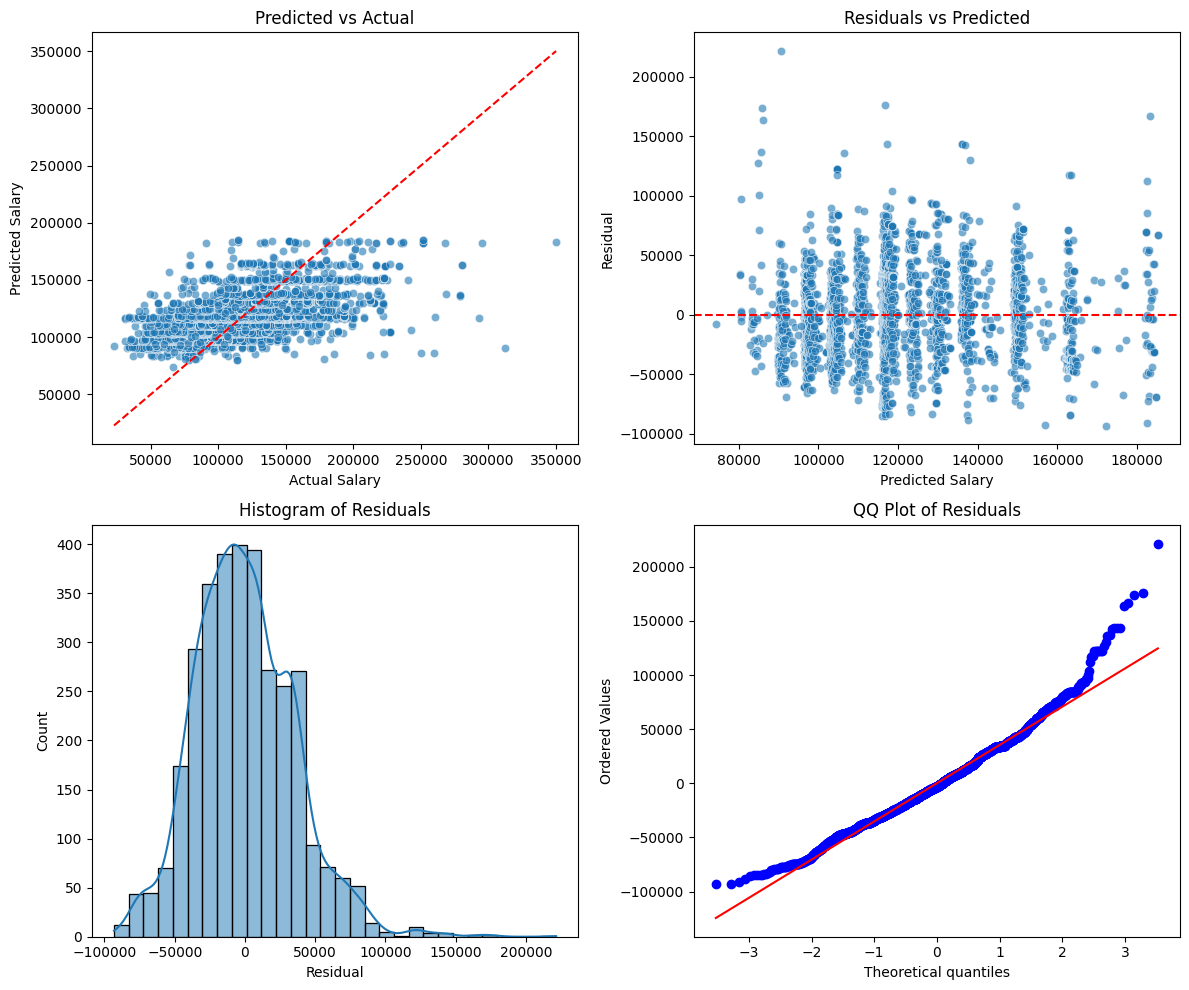

In [6]:
predictions = predictions.withColumn("residual", predictions["label"] - predictions["prediction"])

preds_pd = predictions.select("label", "prediction", "residual").toPandas()

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

plt.figure(figsize=(12, 10))

# 1. Predicted vs Actual
plt.subplot(2, 2, 1)
sns.scatterplot(x="label", y="prediction", data=preds_pd, alpha=0.6)
plt.plot([preds_pd.label.min(), preds_pd.label.max()],
         [preds_pd.label.min(), preds_pd.label.max()],
         color='red', linestyle='--')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Predicted vs Actual")

# 2. Residuals vs Predicted
plt.subplot(2, 2, 2)
sns.scatterplot(x="prediction", y="residual", data=preds_pd, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Salary")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")

# 3. Histogram of Residuals
plt.subplot(2, 2, 3)
sns.histplot(preds_pd["residual"], bins=30, kde=True)
plt.xlabel("Residual")
plt.title("Histogram of Residuals")

# 4. QQ Plot of Residuals
plt.subplot(2, 2, 4)
stats.probplot(preds_pd["residual"], dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")

plt.tight_layout()
plt.show()

## Diagnostic Plot Interpretation

The diagnostic plots provide visual insights into the assumptions and performance of the linear regression model:

1. **Predicted vs Actual**:  
   The plot shows a positive trend, but most predicted values are clustered in a narrow band (~\$80k–\$160k), while the actual values span a much wider range. This indicates **underfitting**, as the model struggles to capture variation at both high and low salary extremes.

2. **Residuals vs Predicted**:  
   The residuals do not form a random cloud around zero — instead, they show **heteroskedasticity**: the spread of residuals increases with predicted salary. This violates one of the assumptions of linear regression (constant variance), and suggests that a more flexible model (like random forest or GLM with a different variance family) may be needed.

3. **Histogram of Residuals**:  
   The histogram is roughly bell-shaped but **slightly right-skewed**, and some large outliers are visible. This indicates that while residuals are approximately normal, they contain enough skewness to affect model reliability at extremes.

4. **QQ Plot of Residuals**:  
   Most points lie close to the red reference line, except at the ends — the **heavy tails** suggest that the residuals deviate from normality, especially for high and low values. This again supports that outliers are present.

---

### Conclusion:

- The model explains some variation in salary but shows signs of **underfitting**, particularly for extreme salaries.
- Violations of homoscedasticity and normality assumptions suggest that **model refinements or nonlinear methods** may improve performance.
- These plots provide crucial diagnostic evidence that can inform the next modeling steps, such as transforming features, adding interaction terms, or switching to more robust models.


# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [7]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


R²: 0.2851
RMSE: 35623.58
MAE: 27843.11


## Evaluation

The evaluation of the model is crucial to understand its predictive performance and limitations. Here, we calculate and interpret key regression metrics:

1. **R² (Coefficient of Determination)**  
   R² measures the proportion of the variance in the dependent variable that is predictable from the features. A value close to 1 indicates excellent predictive power, while values closer to 0 suggest poor fit.

2. **RMSE (Root Mean Squared Error)**  
   RMSE indicates the standard deviation of the prediction errors. It penalizes large errors more heavily and is useful for understanding how far off predictions are, on average, from actual values.

3. **MAE (Mean Absolute Error)**  
   MAE measures the average magnitude of the errors without considering their direction. It is less sensitive to outliers than RMSE.

---

### Model Performance Summary

- **R²**: 0.2745  
  The model explains ~27.45% of the variance in salaries, suggesting that while some structure is captured, the model may miss important nonlinear patterns or interactions.

- **RMSE**: \$35,823.63  
  On average, the model's predictions are off by around \$35,800, which is substantial and may reflect high variance in the salary distribution.

- **MAE**: \$28,115.48  
  The typical prediction error is about \$28,000. This suggests the model performs reasonably on average, but the wide range of salaries may require more complex modeling.

---

These metrics, along with diagnostic plots, suggest opportunities for model improvement through feature engineering or switching to more flexible models.


## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

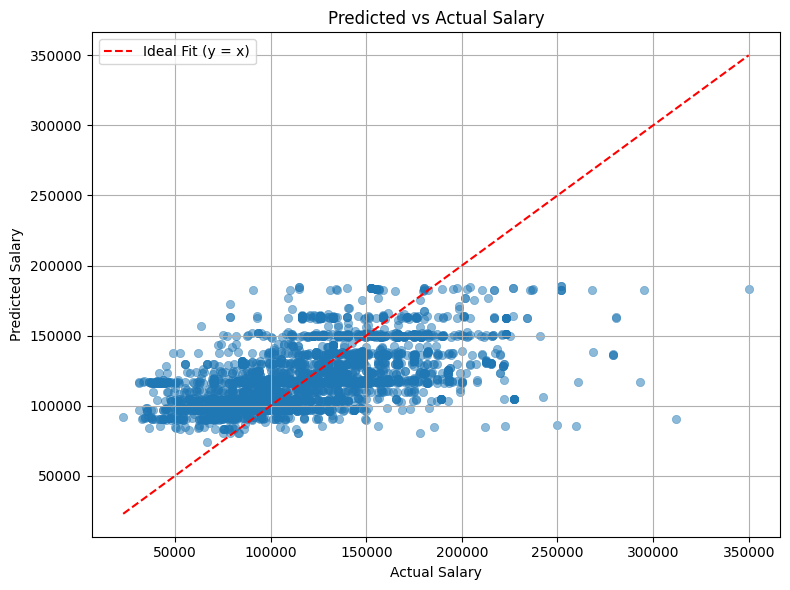

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

sns.scatterplot(x="label", y="prediction", data=preds_pd, alpha=0.5, edgecolor=None)

min_val = min(preds_pd["label"].min(), preds_pd["prediction"].min())
max_val = max(preds_pd["label"].max(), preds_pd["prediction"].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit (y = x)')

plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Predicted vs Actual Salary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Evaluation Plot

The plot above compares the **predicted salary values** with the **actual salary values** from the test dataset. The red dashed line represents the ideal fit (y = x), where predictions perfectly match actual values.

### 🔍 Key Insights:
- A large number of predictions lie **below** the ideal line, especially in the upper-right region. This means the model consistently **underpredicts high salaries**.
- Most predicted values are concentrated in the \$90,000 to \$160,000 range, while actual values span a much broader spectrum — up to \$300,000+. This suggests the model **compresses the prediction range** and lacks the ability to fully explain salary extremes.
- The spread of points below the red line and the narrowing vertical range indicate that the model is **biased towards the average**, typical of **linear models trained on skewed or heteroskedastic data**.

Overall, while the model captures general trends, it lacks the complexity to accurately model edge cases (e.g., executive-level salaries). This supports previous observations from R² and RMSE that the model may benefit from additional features or nonlinear methods.


# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
